In [1]:
import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Failed to read image: /content/drive/MyDrive/dataset/Autism/dataset


<Axes: xlabel='count'>

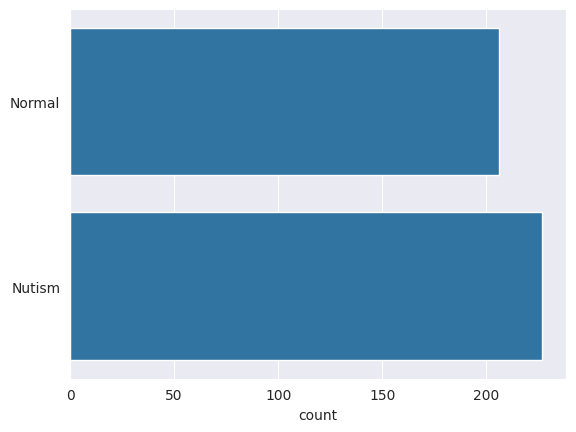

In [3]:
import cv2
import os
import numpy as np
import seaborn as sns

data_dir = r"/content/drive/MyDrive/dataset"
labels = ['Normal', 'Autism']
img_size = 256

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path)
                if img_arr is not None:
                    img_arr = img_arr[...,::-1] # convert BGR to RGB format
                    resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                    data.append([resized_arr, class_num])
                else:
                    print(f"Failed to read image: {img_path}")
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
    return data

# Load data from the dataset directory
data = get_data(data_dir)

# Prepare labels for visualization
labels_list = []
for i in data:
    if i[1] == 0:
        labels_list.append("Normal")
    elif i[1] == 1:
        labels_list.append("Nutism")

# Visualize the distribution of labels
sns.set_style('darkgrid')
sns.countplot(labels_list)


In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

images, labels_list = zip(*data)

# Convert to numpy arrays
images = np.array(images)
# Ensure labels are one-hot encoded
labels_list = to_categorical(labels_list, num_classes=2)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_list, test_size=0.2, random_state=42)

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0



In [5]:
# Building the Model Architecture
model = Sequential()
# Select 6 feature convolution kernels with a size of 5 * 5 (without offset), and get 66 feature maps. The size of each feature map is 32−5 + 1 = 2832−5 + 1 = 28.
# That is, the number of neurons has been reduced from 10241024 to 28 ∗ 28 = 784 28 ∗ 28 = 784.
# Parameters between input layer and C1 layer: 6 ∗ (5 ∗ 5 + 1)
model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(256,256,3)))
# The input of this layer is the output of the first layer, which is a 28 * 28 * 6 node matrix.
# The size of the filter used in this layer is 2 * 2, and the step length and width are both 2, so the output matrix size of this layer is 14 * 14 * 6.
model.add(MaxPooling2D(pool_size=(2, 2)))
# The input matrix size of this layer is 14 * 14 * 6, the filter size used is 5 * 5, and the depth is 16. This layer does not use all 0 padding, and the step size is 1.
# The output matrix size of this layer is 10 * 10 * 16. This layer has 5 * 5 * 6 * 16 + 16 = 2416 parameters
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
# The input matrix size of this layer is 10 * 10 * 16. The size of the filter used in this layer is 2 * 2, and the length and width steps are both 2, so the output matrix size of this layer is 5 * 5 * 16.
model.add(MaxPooling2D(pool_size=(2, 2)))
# The input matrix size of this layer is 5 * 5 * 16. This layer is called a convolution layer in the LeNet-5 paper, but because the size of the filter is 5 * 5, #
# So it is not different from the fully connected layer. If the nodes in the 5 * 5 * 16 matrix are pulled into a vector, then this layer is the same as the fully connected layer.
# The number of output nodes in this layer is 120, with a total of 5 * 5 * 16 * 120 + 120 = 48120 parameters.
model.add(Flatten())
model.add(Dense(4000,activation="relu"))
model.add(Dense(1000,activation="relu"))
model.add(Dense(100,activation="relu"))
model.add(Dense(2, activation="sigmoid"))

In [6]:
import tensorflow as tf
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.000001),
    metrics=['accuracy']
)
model.summary()


train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds=tf.data.Dataset.from_tensor_slices((X_val,y_val))


def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(256,256))

    return image,label



train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)



train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 16)      2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 59536)             0         
                                                                 
 dense (Dense)               (None, 4000)              2

In [7]:
from re import X
print(len(y_train))
print(len(X_train))
print(len(y_val))
print(len(X_val))

346
346
87
87


In [8]:
model.compile(loss=keras.metrics.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/50
 3/10 [========>.....................] - ETA: 44s - loss: 38.3841 - accuracy: 0.5417

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

from sklearn.metrics import classification_report
predictions = model.predict_classes(x_val)
from sklearn.metrics import confusion_matrix
print(classification_report(y_valA, predictions, target_names = ['CN60_69','MCI60_69']))

cm = confusion_matrix(y_valA, predictions)
sns.heatmap(cm, annot= True, fmt='d')

print(cm)

fig = plt.figure()

ax = fig.add_subplot(111)

cax = ax.matshow(cm)

plt.title('Confusion matrix of the classifier')

fig.colorbar(cax)

ax.set_xticklabels([''] + labels)

ax.set_yticklabels([''] + labels)

plt.xlabel('Predicted')

plt.ylabel('True')

plt.show()





print(classification_report(y_valA, predictions, target_names = ['CN60_69','CN60_69']))



In [ ]:
history = model.fit(x_train3,y_train3,epochs = 50 , validation_data = (x_val3, y_val3))

In [ ]:
import matplotlib.pyplot as plt
acc3 = history.history['accuracy']
val_acc3 = history.history['val_accuracy']
loss3 = history.history['loss']
val_loss3 = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc3, label='Training Accuracy')
plt.plot(epochs_range, val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss3, label='Training Loss')
plt.plot(epochs_range, val_loss3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

from sklearn.metrics import classification_report
predictions3 = model.predict_classes(x_val3)

print(classification_report(y_valC, predictions3, target_names = ['CN60_69','AD60_69']))


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predictions3, y_valC)
sns.heatmap(cm, annot= True, fmt='d')
